
Метод: raw
n_trees=10, top_k=3 => ROC-AUC=0.8025
n_trees=10, top_k=4 => ROC-AUC=0.8082
n_trees=10, top_k=5 => ROC-AUC=0.8123
n_trees=10, top_k=6 => ROC-AUC=0.8124
n_trees=10, top_k=7 => ROC-AUC=0.8129
n_trees=10, top_k=8 => ROC-AUC=0.8156
n_trees=10, top_k=9 => ROC-AUC=0.8168
n_trees=10, top_k=10 => ROC-AUC=0.8166
n_trees=15, top_k=3 => ROC-AUC=0.8024
n_trees=15, top_k=4 => ROC-AUC=0.8091
n_trees=15, top_k=5 => ROC-AUC=0.8126
n_trees=15, top_k=6 => ROC-AUC=0.8125
n_trees=15, top_k=7 => ROC-AUC=0.8131
n_trees=15, top_k=8 => ROC-AUC=0.8153
n_trees=15, top_k=9 => ROC-AUC=0.8158
n_trees=15, top_k=10 => ROC-AUC=0.8165
n_trees=20, top_k=3 => ROC-AUC=0.8017
n_trees=20, top_k=4 => ROC-AUC=0.8083
n_trees=20, top_k=5 => ROC-AUC=0.8116
n_trees=20, top_k=6 => ROC-AUC=0.8129
n_trees=20, top_k=7 => ROC-AUC=0.8136
n_trees=20, top_k=8 => ROC-AUC=0.8148
n_trees=20, top_k=9 => ROC-AUC=0.8158
n_trees=20, top_k=10 => ROC-AUC=0.8158
n_trees=25, top_k=3 => ROC-AUC=0.8025
n_trees=25, top_k=4 => ROC-AUC=0.80

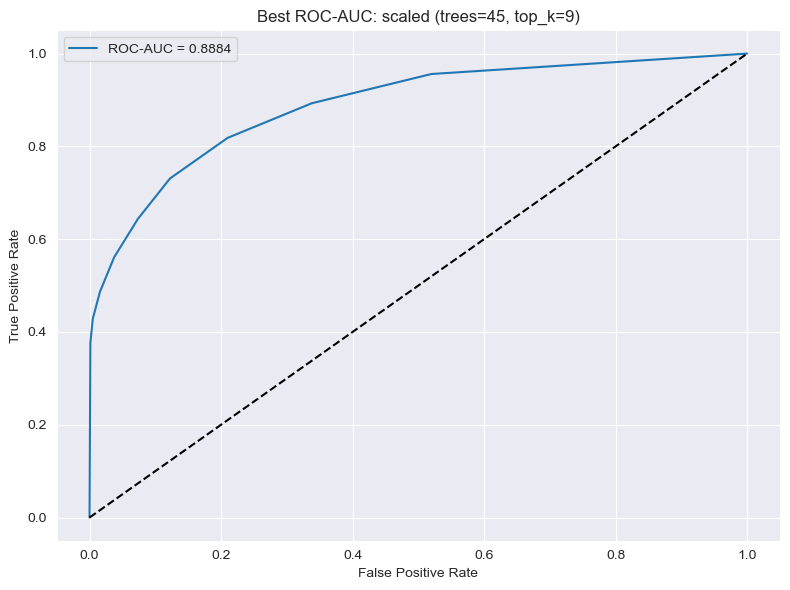

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from annoy import AnnoyIndex
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
from tqdm import tqdm

RANDOM_SEED = 47

# Гиперпараметры
n_trees_list = [10, 15, 20, 25, 30, 40, 45, 50]
top_k_list = [3, 4, 5, 6, 7, 8, 9, 10]
metric = 'angular'

# Загрузка данных
train = pd.read_csv('../train_final_processed.csv')
X = train.drop(columns=["is_canceled"])
y = train["is_canceled"]

# Разделение на train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Преобразования
def transform_data(X_train, X_valid, method):
    if method == "raw":
        return X_train, X_valid
    elif method == "scaled":
        scaler = StandardScaler()
        return scaler.fit_transform(X_train), scaler.transform(X_valid)
    elif method == "pca":
        pca = PCA(n_components=X_train.shape[1])
        return pca.fit_transform(X_train), pca.transform(X_valid)
    elif method == "scaled+pca":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        pca = PCA(n_components=X_train.shape[1])
        return pca.fit_transform(X_train_scaled), pca.transform(X_valid_scaled)

# Обучение Annoy
def train_annoy_model(X_train_ann, n_trees=10, metric='angular'):
    X_np = X_train_ann.to_numpy() if isinstance(X_train_ann, pd.DataFrame) else X_train_ann
    dim = X_np.shape[1]
    annoy_index = AnnoyIndex(dim, metric)
    for i in range(len(X_np)):
        annoy_index.add_item(i, X_np[i])
    annoy_index.build(n_trees)
    return annoy_index

# Предсказание вероятностей
def predict_annoy_proba(index, X_valid, y_train, top_k=5):
    X_np = X_valid.to_numpy() if isinstance(X_valid, pd.DataFrame) else X_valid
    proba = []
    for v in tqdm(X_np, disable=True):
        idxs = index.get_nns_by_vector(v, top_k)
        votes = [y_train.iloc[i] for i in idxs]
        proba.append(np.mean(votes))  # вероятность класса 1
    return np.array(proba)

# Глобальное хранение
global_best_auc = 0
global_best_info = {}

# Основной цикл
for method in ['raw', 'scaled', 'pca', 'scaled+pca']:
    print(f"\nМетод: {method}")
    X_tr, X_val = transform_data(X_train, X_valid, method)

    best_auc = 0
    best_params = (None, None)
    best_y_score = None

    for n_trees in n_trees_list:
        for top_k in top_k_list:
            annoy = train_annoy_model(X_tr, n_trees=n_trees, metric=metric)
            y_score = predict_annoy_proba(annoy, X_val, y_train, top_k=top_k)
            auc = roc_auc_score(y_valid, y_score)
            print(f"n_trees={n_trees}, top_k={top_k} => ROC-AUC={auc:.4f}")

            if auc > best_auc:
                best_auc = auc
                best_params = (n_trees, top_k)
                best_y_score = y_score

    print(f"Лучшие параметры для {method}: n_trees={best_params[0]}, top_k={best_params[1]} => ROC-AUC={best_auc:.4f}")

    # Проверка на глобальный максимум
    if best_auc > global_best_auc:
        global_best_auc = best_auc
        global_best_info = {
            "method": method,
            "n_trees": best_params[0],
            "top_k": best_params[1],
            "y_score": best_y_score,
            "y_true": y_valid
        }

# Метрики для лучшего варианта
y_true = global_best_info["y_true"]
y_score = global_best_info["y_score"]
y_pred = (y_score >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_score)

print("\nМетрики для лучшей модели:")
print(f"Метод: {global_best_info['method']}")
print(f"n_trees = {global_best_info['n_trees']}, top_k = {global_best_info['top_k']}")
print(f"Accuracy  = {acc:.4f}")
print(f"Precision = {prec:.4f}")
print(f"Recall    = {rec:.4f}")
print(f"F1-score  = {f1:.4f}")
print(f"ROC-AUC   = {roc_auc:.4f}")

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Best ROC-AUC: {global_best_info['method']} (trees={global_best_info['n_trees']}, top_k={global_best_info['top_k']})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
